In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LassoCV, LassoLarsCV
import warnings
import sys
import os
import pickle
from sympy import *
# ignoramos os resultados NaN das funções pois vamnos zera-los
np.seterr(invalid='ignore')
# nao quero warning de convergência
warnings.filterwarnings('ignore')

In [2]:
def getResults(fname):
    dataset = []
    algoritmo = []
    msre_l = []
    coef_l = []
    rede_l = []
    if os.path.exists(fname):
        fw = open(fname, 'rb')
        dataset, algoritmo, msre_l, coef_l, rede_l = pickle.load(fw)
        fw.close()
    return dataset, algoritmo, msre_l, coef_l, rede_l

In [3]:
def storeResults(dataset, algoritmo, msre_l, coef_l, rede_l, fname):
    fw = open(fname, 'wb')
    pickle.dump((dataset, algoritmo, msre_l, coef_l, rede_l), fw)
    fw.close()

In [4]:
def msre(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [5]:
def importaDados(fname):
    dataset = np.loadtxt(fname, delimiter=",")
    X = dataset[:, :-1]
    y = dataset[:, -1]
    return (X, y)

In [6]:
def geraRede(X, n_inter, inter_min=0, inter_max=3):
    n_inputs = X.shape[1]
    rede = np.random.randint(inter_min, inter_max, size=(n_inputs, n_inter))
    for i in range(0, n_inputs):
        if 0 in X[:,i]:
            rede[i,:] = np.absolute(rede[i,:])
    return rede

In [7]:
def transformData(X, rede):
    n_rows = X.shape[0]
    n_inter = rede.shape[1]
    layers = np.ndarray((n_rows, 3*n_inter))
    for i in range(0, n_inter*3, 3):
        power = X**rede[:,int(i/3)]
        layers[:,i] = np.prod(power,axis=1) # id
        layers[:,i+1] = np.cos(layers[:,i]) # cos
        layers[:,i+2] = np.sqrt(layers[:,i]) # sqrt
    cols = np.any(np.isnan(layers), axis=0)
    layers[:, cols] = 0
    cols = np.any(np.isinf(layers), axis=0)
    layers[:, cols] = 0
    return layers

In [8]:
def fit(X, y, algoritmo, n_inter, inter_min=0, inter_max=3):
    n_inputs = X.shape[1]
    rede = geraRede(X, n_inter, inter_min, inter_max)
    X_transf = transformData(X, rede)
    if algoritmo == 'lasso':
        modelo = LassoCV(max_iter=5e4, cv=3)
    elif algoritmo == 'lassoLars':
        modelo = LassoLarsCV(max_iter=5e4, cv=3)
    modelo.fit(X_transf, y)
    return rede, modelo

In [9]:
def predict(X, rede, modelo):
    X_transf = transformData(X, rede)
    y_hat = modelo.predict(X_transf)
    return y_hat

In [10]:
def expression(rede, coef, limiar):
    n_inter = rede.shape[1]
    n_inputs = rede.shape[0]
    fun = ['', 'cos', 'sqrt']
    expr = ''
    total = 0
    for i in range(n_inter):
        inter = ''
        for j in range(n_inputs):
            if rede[j,i] != 0:
                inter = inter + f'x{j}**{rede[j,i]}*'
        inter = inter[:-1]
        transf = ''
        for f in range(3):
            k = (i*3)+f
            if np.absolute(coef[k]) > limiar:
                total = total + 1
                transf = transf + f'{coef[k]}*{fun[f]}({inter}) + '
        expr = expr + transf
    expr = expr + f'{coef[k+1]}'
    return expr, total

In [11]:
def evaluate(row, rede, coef, limiar):
    n_inter = rede.shape[1]
    n_inputs = rede.shape[0]
    total = 0.0
    for i in range(n_inter):
        inter = 1.0
        for j in range(n_inputs):
            inter *= np.power(float(row[j]),rede[j,i])
        transf = 0.0
        if np.absolute(coef[i*3+0]) > limiar:
            transf += coef[(i*3)+0]*inter
        if np.absolute(coef[i*3+1]) > limiar:
            transf += coef[(i*3)+1]*np.cos(inter)
        if np.absolute(coef[i*3+2]) > limiar:
            transf += coef[(i*3)+2]*np.sqrt(inter)
        total += transf
    total += coef[-1]
    return total

In [12]:
datasets = ['airfoil', 'concrete', 'cpu', 'energyCooling', 'energyHeating', 'forestfires', 'towerData', 'wineRed', 'wineWhite', 'yacht']
algoritmos = ['lassoLars', 'lassoLars', 'lassoLars', 'lassoLars', 'lassoLars', 'lasso', 'lassoLars', 'lassoLars', 'lassoLars', 'lassoLars']
ninters = [10, 500, 1000, 500, 500, 10, 10, 100, 100, 100]
inter_mins = [-2, -2, -3, -2, 0, -2, 0, -1, -1, -3]
inter_maxs = [2, 2, 3, 2, 4, 2, 2, 1, 1, 3]
pastas = ['0', '1', '2', '3', '4']

In [ ]:
# faça esse somente para rodar todos os testes novamente
dataset_l = []
algoritmo_l = []
msre_l = []
coef_l = []
rede_l = []

for i in range(1):
    dataset_l.append(datasets[i])
    algoritmo_l.append(f'{algoritmos[i]} {ninters[i]} ({inter_mins[i]} {inter_maxs[i]})')
    msre_pastas = []
    coef_pastas = []
    rede_pastas  =[]
    print(f'dataset {datasets[i]}')
    for pasta in pastas:
        fileTrain = 'datasets/' + datasets[i] + '-train-' + pasta + '.dat'
        fileTest = 'datasets/' + datasets[i] + '-test-' + pasta + '.dat'
        X_train, y_train = importaDados(fileTrain)
        X_test, y_test = importaDados(fileTest)
        n = X_train.shape[1]
        rede, modelo = fit(X_train, y_train, algoritmos[i], ninters[i]*n, inter_mins[i], inter_maxs[i]+1)
        y_hat = predict(X_test, rede, modelo)
        msre_pastas.append(msre(y_test, y_hat))
        coef = np.append(modelo.coef_, modelo.intercept_)
        coef_pastas.append(coef)
        rede_pastas.append(rede)
    m = len(pastas)
    msre_medio = np.sum(msre_pastas)/m
    msre_l.append(msre_medio)
    min_i = np.argmin(msre_pastas)
    print(f'{datasets[i]} {algoritmos[i]} {ninters[i]} ({inter_mins[i]} {inter_maxs[i]}) msre: {msre_medio}')
    print('total de coeficientes não-zeros:', np.count_nonzero(coef_pastas[min_i]))
    coef_l.append(coef_pastas[min_i])
    rede_l.append(rede_pastas[min_i])

storeResults(dataset_l, algoritmo_l, msre_l, coef_l, rede_l, 'tests.pkl')

In [23]:
# faça esse ao invés da acima para carregar os resultados salvos
dataset_l, algoritmo_l, msre_l, coef_l, rede_l = getResults('tests.pkl')

In [38]:
init_printing(use_unicode=True)

In [14]:
limiar = 1e-04

In [36]:
expr, nz = expression(rede_l[0], coef_l[0], limiar)
print('total de coeficientes não-zeros com limiar', limiar, ':', nz)

total de coeficientes não-zeros com limiar 0.0001 : 91


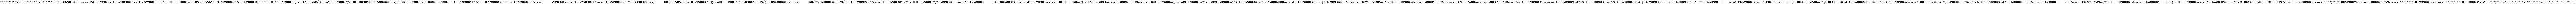

In [39]:
sympify(expr)

In [40]:
latex(sympify(expr))

'\\frac{0.00016869861235403058 x_{0}^{2}}{x_{3}^{2}} x_{1}^{2} x_{2}^{2} + \\frac{0.1903209662163933 x_{4}}{x_{3}^{2}} x_{0}^{2} x_{2}^{2} + \\frac{0.003571845775598759 x_{0}}{x_{3}^{2}} x_{1}^{2} - \\frac{105.71694461669641 x_{1}^{2}}{x_{3}} x_{4}^{2} + 8712.916507944376 x_{2}^{2} x_{4} + 0.4822250646478931 \\sqrt{\\frac{x_{0}}{x_{3}}} - 0.019627775715366183 \\sqrt{\\frac{x_{0}^{2}}{x_{3}}} - 458.18651539948956 \\sqrt{x_{2}^{2} x_{4}} - 7.35724218352519 \\sqrt{\\frac{x_{1}}{x_{0}^{2} x_{2}}} + 41.77845739585989 \\sqrt{\\frac{x_{3}^{2} x_{4}}{x_{0}}} - 0.6746387548533386 \\sqrt{\\frac{x_{0} x_{1}^{2}}{x_{3}^{2}}} - 0.0046707924793558215 \\sqrt{\\frac{1}{x_{2}^{2} x_{3}^{2} x_{4}^{2}}} + 64.45470092010244 \\sqrt{\\frac{x_{1} x_{2}^{2}}{x_{0}^{2}} x_{3}^{2}} - 225.80491995988393 \\sqrt{\\frac{x_{1} x_{3}}{x_{0}^{2}} x_{4}^{2}} + 536.3344404515701 \\sqrt{\\frac{x_{1}^{2} x_{2}^{2}}{x_{0}^{2} x_{4}}} + 7.489066223507851 \\sqrt{\\frac{x_{1} x_{4}}{x_{0} x_{2}^{2}}} + 8.12415609995818 \\sqrt

In [27]:
for i in range(1):
    dataset_l.append(datasets[i])
    algoritmo_l.append(f'expressão com limiar {limiar}')
    print(f'dataset {datasets[i]}')
    msre_total = 0
    for pasta in pastas:
        fileTest = 'datasets/' + datasets[i] + '-test-' + pasta + '.dat'
        X_test, y_test = importaDados(fileTest)
        m, n = X_test.shape
        y_hat = []
        for r in range(m):
            y_hat.append(evaluate(X_test[r], rede_l[i], coef_l[i], limiar))
        msre_total += msre(y_test, y_hat)
    m = len(pastas)
    msre_medio = msre_total/m
    msre_l.append(msre_medio)
    expr, nz = expression(rede_l[0], coef_l[0], limiar)
    print(f'{algoritmos[i]} {ninters[i]} ({inter_mins[i]} {inter_maxs[i]}) total de coeficientes não-zeros: {np.count_nonzero(coef_l[i])} msre: {msre_l[i]}')
    print(f'expressão com limiar: {limiar} total de coeficientes não-zeros: {nz} msre: {msre_medio}')

dataset airfoil
lassoLars 10 (-2 2) total de coeficientes não-zeros: 114 msre: 2.9010154415409932
expressão com limiar: 0.0001 total de coeficientes não-zeros: 91 msre: 8.621297460285644


In [31]:
# gerar o dataframe de resultados
df_IT = pd.DataFrame({'dataset':dataset_l, 'algoritmo':algoritmo_l, 'rmse':msre_l})

In [ ]:
# salvar o df no arquivo
fw = open('df_IT.pkl', 'wb')
pickle.dump(df_IT, fw)
fw.close()

In [ ]:
# carregar o df do arquivo de resultados
fw = open('df_IT.pkl', 'rb')
df_IT = pickle.load(fw)
fw.close()

In [32]:
# carregar o df do arquivo de resultados dos outros algoritmos
fw = open('df_GS.pkl', 'rb')
df_GS = pickle.load(fw)
fw.close()

In [33]:
# unir os resultados desses testes com os testes do GridSearch
df = pd.concat([df_IT, df_GS], ignore_index=True)

In [34]:
datasets = df_IT.dataset.unique()
for D in datasets:
    print('\n', D)
    print(df.loc[df['dataset'] == D])


 airfoil
                      algoritmo  dataset      rmse
0           lassoLars 10 (-2 2)  airfoil  2.901015
1   expressão com limiar 0.0001  airfoil  8.621297
20                        Ridge  airfoil  4.862221
21                        Lasso  airfoil  6.142515
22                         Lars  airfoil  4.819300
23                   ElasticNet  airfoil  6.169792
24                      XGBoost  airfoil  2.186636
25                          MLP  airfoil  4.811583
